<a href="https://colab.research.google.com/github/himangan/Arduino/blob/master/text_summarizer_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from bs4 import BeautifulSoup
from tensorflow.keras.layers import Bidirectional, LSTM, Input, Embedding, Dense, TimeDistributed, Concatenate, Attention
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
data=pd.read_csv("Reviews.csv",error_bad_lines=False, engine="python")
data2=data.iloc[:7000,:]
data=data2
len(data)


5000

Removing all duplicate and NA records

In [6]:
data.drop_duplicates(subset = ['Text'], inplace = True)
data.dropna(axis = 0, inplace = True)

Function for cleaning the text data

In [7]:
def cleaner(text, remove_stopwords=True):
  """removes url's, nltk's stopwords and anything which is not an alphabet"""
  
  stop_words = set(stopwords.words('english'))
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text.lower(), flags=re.MULTILINE)
  text = re.sub(r'[^a-zA-Z]', ' ', text)
  text = contractions.fix(text, slang=False)
  if remove_stopwords:
    text = ' '.join([word for word in text.split() if word not in stop_words]).strip()
  return text

In [8]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 39.7 MB/s 
     |████████████████████████████████| 106 kB 72.0 MB/s 


In [9]:
import contractions
from time import time
from math import ceil

t1 = time()
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(cleaner(t))

t2 = time()
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(cleaner(t, remove_stopwords = False))

t3 = time()
print('Text cleaned in {} sec, and Summary in {} sec'.format(ceil(t2-t1), ceil(t3-t2)))

data = pd.DataFrame({
    'text'    :   cleaned_text,
    'summary' :   cleaned_summary})

data.replace('', np.nan, inplace = True)
data.dropna(axis = 0, inplace = True)

Text cleaned in 1 sec, and Summary in 1 sec


In [10]:
data.reset_index(inplace=True, drop=True)

Looking at the number of words in the records

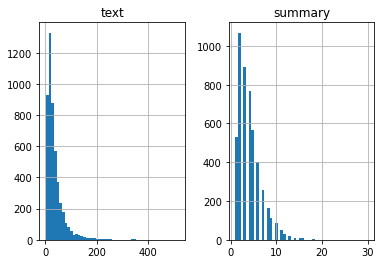

In [11]:
text_word_count    = []
summary_word_count = []

for i in data['text']:
      text_word_count.append(len(i.split()))

for i in data['summary']:
      summary_word_count.append(len(i.split()))

visualize = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
visualize.hist(bins = 50)
plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

In [12]:
cnt = 0
for i in range(data.shape[0]):
  if len(data['text'][i].split()) <= 60 and len(data['summary'][i].split()) <= 10:
    cnt += 1
print(cnt)

4132


In [33]:
_MAX_SUMMARY_LEN = 10
_MAX_TEXT_LEN    = 60
# Declaring the important variables here, which will be used later down the notebook

_NROWS           =   100000
_TEXT_PADDING    =   'post'
_EMBEDDING_DIM   =   500
_ENCODER_DIM     =   300
_DECODER_DIM     =   600
_BATCH_SIZE      =   15
_EPOCHS          =   40

In [34]:
def prepare(dataset):
  global _MAX_SUMMARY_LEN, _MAX_TEXT_LEN
  newtext    =  []
  newsummary =  []
  
  for i in range(len(dataset['text'])):
    if len(dataset['text'][i].split()) <= _MAX_TEXT_LEN and len(dataset['summary'][i].split()) <= _MAX_SUMMARY_LEN:
      newtext.append(dataset['text'][i])
      newsummary.append(dataset['summary'][i])

  dataset = pd.DataFrame({'text'    : newtext,
                          'summary' : newsummary})
  dataset['summary'] = dataset['summary'].apply(lambda row : 'stok ' + row + ' etok')
  dataset.reset_index(drop=True, inplace=True)
  return dataset

In [35]:
df = prepare(data)

In [36]:
df.head()

,text,summary
0,bought several vitality canned dog food produc...,stok good quality dog food etok
1,product arrived labeled jumbo salted peanuts p...,stok not as advertised etok
2,confection around centuries light pillowy citr...,stok delight says it all etok
3,looking secret ingredient robitussin believe f...,stok cough medicine etok
4,great taffy great price wide assortment yummy ...,stok great taffy etok


In [37]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.1, random_state=42)

In [38]:
# preparing 'text' for model training and validation
tok_x  = Tokenizer()
tok_x.fit_on_texts(list(x_tr))
x_tr    =  pad_sequences(tok_x.texts_to_sequences(x_tr),  maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
x_val   =  pad_sequences(tok_x.texts_to_sequences(x_val), maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
vocab_x =  len(tok_x.word_counts) + 1

In [39]:
vocab_x

8858

In [40]:
# preparing 'summary' for model training and validation
tok_y  = Tokenizer()
tok_y.fit_on_texts(list(y_tr))
y_tr    =  pad_sequences(tok_y.texts_to_sequences(y_tr),  maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
y_val   =  pad_sequences(tok_y.texts_to_sequences(y_val), maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
vocab_y =  len(tok_y.word_counts) + 1

In [41]:
vocab_y

2419

In [42]:
tok_y.word_counts['stok'], len(y_tr)

(3718, 3718)

In [43]:
index_to_word_text    =  tok_x.index_word
index_to_word_summary =  tok_y.index_word
word_to_index_summary =  tok_y.word_index

In [44]:
# Encoder
encoder_input  =  Input(shape=(_MAX_TEXT_LEN,), name='Encoder_input')
encoder_embed  =  Embedding(vocab_x, _EMBEDDING_DIM, trainable=True, name='Encoder_embedding')(encoder_input)
encoder        =  Bidirectional(LSTM(_ENCODER_DIM, 
                                     return_sequences=True,
                                     return_state=True,
                                     dropout=0.4, recurrent_dropout=0.4), name='Encoder_layer')
encoder_output, forward_h, forward_c, backward_h, backward_c = encoder(encoder_embed)
state_h        =  Concatenate()([forward_h, backward_h])
state_c        =  Concatenate()([forward_c, backward_c])

# Decoder
decoder_input        =  Input(shape=(None,), name='Decoder_input')
decoder_embed_layer  =  Embedding(vocab_y, _EMBEDDING_DIM, trainable=True, name='Decoder_embedding')
decoder_embed        =  decoder_embed_layer(decoder_input)
decoder              =  LSTM(_DECODER_DIM,
                             return_sequences=True,
                             return_state=True,
                             dropout=0.4, recurrent_dropout=0.3, name='Decoder_layer')
decoder_output, decoder_state_h, decoder_state_c = decoder(decoder_embed,initial_state=[state_h, state_c])

# Attention layer
attention_layer =  Attention(name='Attention_layer')
attention_out   =  attention_layer([decoder_output, encoder_output])

# Concat attention layer's output and decoder's output
concat_layer    =  Concatenate(axis=-1, name='Concat_layer')([decoder_output, attention_out])

# Dense layer
decoder_dense   =  TimeDistributed(Dense(vocab_y, activation='softmax'))
decoder_output  =  decoder_dense(concat_layer)

# Model 
model           =  Model([encoder_input, decoder_input], decoder_output, name='Model')

model.summary()

Model: "Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_input (InputLayer)     [(None, 60)]         0           []                               
                                                                                                  
 Encoder_embedding (Embedding)  (None, 60, 500)      4429000     ['Encoder_input[0][0]']          
                                                                                                  
 Decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 Encoder_layer (Bidirectional)  [(None, 60, 600),    1922400     ['Encoder_embedding[0][0]']      
                                 (None, 300),                                                 

In [45]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

stopearly =  EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
X         =  [x_tr,y_tr[:,:-1]]
y         =  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:] 
VAL_X     =  [x_val,y_val[:,:-1]]
VAL_y     =  y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]
history   =  model.fit(X, y, epochs=10, callbacks=[stopearly], batch_size=_BATCH_SIZE, validation_data=(VAL_X, VAL_y))

Epoch 1/10
248/248 [==============================] - 186s 724ms/step - loss: 0.5727 - val_loss: 0.3771
Epoch 2/10
248/248 [==============================] - 178s 717ms/step - loss: 0.4104 - val_loss: 0.3649
Epoch 3/10
248/248 [==============================] - 177s 716ms/step - loss: 0.3925 - val_loss: 0.3653
Epoch 4/10
248/248 [==============================] - 177s 712ms/step - loss: 0.3701 - val_loss: 0.3585
Epoch 5/10
248/248 [==============================] - 177s 713ms/step - loss: 0.3435 - val_loss: 0.3558
Epoch 6/10
248/248 [==============================] - 176s 709ms/step - loss: 0.3154 - val_loss: 0.3546
Epoch 7/10
248/248 [==============================] - 178s 720ms/step - loss: 0.2845 - val_loss: 0.3593
Epoch 8/10
248/248 [==============================] - 174s 704ms/step - loss: 0.2494 - val_loss: 0.3677
Epoch 8: early stopping


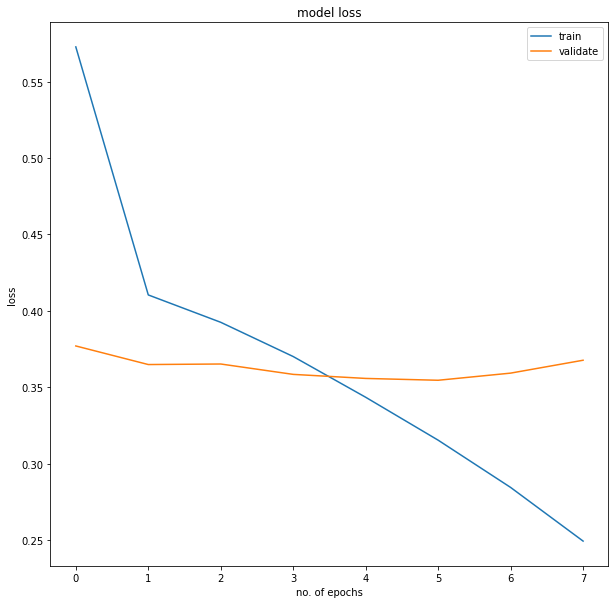

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('no. of epochs')
plt.ylabel('loss')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [46]:
encoder_model = Model(inputs  = encoder_input,
                outputs = [encoder_output, state_h, state_c])

# For storing decoder's previous states which will act as our encoder here
decoder_previous_state_h = Input(shape=(_DECODER_DIM,))
decoder_previous_state_c = Input(shape=(_DECODER_DIM,))
decoder_previous_output  = Input(shape=(_MAX_TEXT_LEN, _DECODER_DIM))

# This new decoder will take the 'previous decoder' i.e, our encoder's output
decoder_embed_new = decoder_embed_layer(decoder_input)
decoder_output_new, state_h_new, state_c_new = decoder(decoder_embed_new,
                                                       initial_state = [decoder_previous_state_h, decoder_previous_state_c])

# Attention layer & concat layer for the new decoder and encoder
attention_out_new    =  attention_layer([decoder_output_new, decoder_previous_output])
concat_layer_final   =  Concatenate(axis=-1)([decoder_output_new, attention_out_new])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_output_final =  decoder_dense(concat_layer_final)

# Final decoder model
decoder_model = Model(
    [decoder_input] + [decoder_previous_output, decoder_previous_state_h, decoder_previous_state_c],
    [decoder_output_final] + [state_h_new, state_c_new])

In [47]:
def summarizer(input_seq):
    encoder_out, encoder_h, encoder_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = word_to_index_summary['stok']
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [encoder_out, encoder_h, encoder_c])
        # Greedy decoder
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = index_to_word_summary[sampled_token_index]
        
        if sampled_token != 'etok':
            decoded_sentence += sampled_token + ' '

        if sampled_token == 'etok' or len(decoded_sentence.split()) >= (_MAX_SUMMARY_LEN-1):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        encoder_h, encoder_c = h, c

    return decoded_sentence

In [48]:
def sequence_to_summary(input_seq):
    s = ''
    for i in input_seq:
        if i != 0 and i != word_to_index_summary['stok'] and i != word_to_index_summary['etok']:
            s += index_to_word_summary[i] + ' '
    return s

def sequence_to_text(input_seq):
    s = ''
    for i in input_seq:
        if i != 0:
            s += index_to_word_text[i] + ' '
    return s

In [49]:
for i in range(5):
    print("Review:",sequence_to_text(x_tr[i]))
    print("Original summary:",sequence_to_summary(y_tr[i]))
    print("Predicted summary:",summarizer(x_tr[i].reshape(1,_MAX_TEXT_LEN)))
    print("\n")

Review: coffee really bold opinion falls along medium roast flavor decent smooth coffee think really bold like k cups though seriously overpriced 
Original summary: good coffee 
Predicted summary: good coffee 


Review: used pioneer gravy number years easy make tastes great also goes well mashed potatoes meats etc try 
Original summary: pioneer gravy is great 
Predicted summary: delicious 


Review: flaxseed great way get fiber diet brand delivers mild taste put tablespoons morning smoothie gives daily fiber required intake flaxseed also contain omega also place powerhouse nutrients diet little seed br br excellent source protein fiber minerals magnesium copper go wrong 
Original summary: fiber packed and nutrient rich 
Predicted summary: fiber perfection 


Review: besides smaller runts look consistency unfortunately taste nothing like banana runts even taste good yucky stuff trying return vendor 
Original summary: not banana runts 
Predicted summary: not bad 


Review: trying get sug

In [50]:
for i in range(5):
    print("Review:",sequence_to_text(x_val[i]))
    print("Original summary:",sequence_to_summary(y_val[i]))
    print("Predicted summary:",summarizer(x_val[i].reshape(1,_MAX_TEXT_LEN)))
    print("\n")

Review: good price product started baby similac soy formula much son tummy formula change unfortunately came funky time similac big recall larger containers buying oz wholesale store smaller containers sold local stores fun situation finding pack reasonable price much needed appreciated rescue 
Original summary: sensitive 
Predicted summary: i like this 


Review: sure product chicken rice really sure chicken rice mostly gravy still like 
Original summary: chicken and rice 
Predicted summary: not as the picture 


Review: sweetarts memories going candy store sweet sour chalky taste classic candy hard candy easily chewable pleasant texture taste really go wrong candy drawback hard stop one know eaten entire roll 
Original summary: classic candy 
Predicted summary: not sure 


Review: rice crackers truly delicious w cheese peanut butter also eat crackers w gluten allergic wheat eggs gluten br favorite snack sunday nights come promptly save money thank j wolf 
Original summary: crispy cra

In [60]:
def tryit(sent):
  """wrapper function to test the model"""

  sent = cleaner(sent, remove_stopwords=True)
  if len(sent.split()) > _MAX_TEXT_LEN:
    return "make your sentence length less than {} words".format(_MAX_TEXT_LEN)

  seq = tok_x.texts_to_sequences(sent.split())
  seq = [[item for sublist in seq for item in sublist]]
  seq = pad_sequences(seq, maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
  return summarizer(seq.reshape(1,_MAX_TEXT_LEN))

In [69]:
text = 'We tried the Megna for the first time last night and the food was great, freshly cooked very tasty and well presented. \
The waiters were attentive and service overall was good. The restaurant looked to have been recently decorated. \
Overall a good meal and great value we will certainly be going back.'

In [70]:
tryit(text)

'great for the price '

So we can see that even for a custom review that i picked out of a random restaurants page, our model gives us a pretty decent output summary and hence we can say we were succesful in making an abstractive text summarizer